## Loading BDE dataset and model architecture

In [1]:
import sys
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
def load_BDE_dataset_and_model():
    def __load_dataset():
        # Load Data. Merge All data and perform the split after
        INPUT_PATH = "./data_BDE/"
        input_file="%sDATA_GENERIC.csv" % INPUT_PATH
        df = pd.read_csv(input_file, delimiter=";")
        input_file_test = "%sDATA_GENERIC_VALIDATION.csv" % INPUT_PATH
        df_test = pd.read_csv(input_file_test, delimiter=";")
        #Concatenate Test
        df = pd.concat([df, df_test])

        # Dummy for the State
        df_dummies = pd.get_dummies(df["Input_08"])
        df_global = pd.concat([df.drop(['OUTPUT','Input_08'], axis = 1), df_dummies], axis=1, join_axes=[df.index])
        # Scale real Input
        fit_colnames = ['Input_01','Input_02','Input_03','Input_04','Input_05','Input_06']
        scaler = StandardScaler()
        scaler.fit(df_global[fit_colnames])
        
        # Split Dataset
        df_train, df_test, y_train, y_test = train_test_split(df_global, df['OUTPUT'], test_size=0.4,random_state=42)
        df_test, df_val, y_test, y_val = train_test_split(df_test, y_test, test_size=0.5,random_state=42)

        bs = 10000
        class DataSetRops(Dataset):
            def __init__(self, X, y):
                if not torch.is_tensor(X):
                    self.X = torch.tensor(X.values, dtype=torch.float64)
                if not torch.is_tensor(y):
                    self.y = torch.tensor(y.values, dtype=torch.float64)
            def __len__(self):
                return len(self.X)
            def __getitem__(self, idx):
                return self.X[idx], self.y[idx]
        data_torch = DataSetRops(df_train, y_train)
        dataloader = DataLoader(data_torch, batch_size=bs,shuffle=True)
        return dataloader, scaler, fit_colnames, df_train, y_train, df_val, y_val, df_test, y_test
    
    def __load_model(scaler, fit_colnames):
        import model_torch
        # Create the NN
        torch.manual_seed(533)
        # Parameters of the NN architecture
        nb_in, nb_out= 13, 1
        nb_layer = 4
        nb_hidden = [64,64,64,64]
        # Create the model
        model = model_torch.Net(nb_layer, nb_in, nb_out, nb_hidden)
        model.set_scaler(scaler, fit_colnames)
        return model

    dataloader, scaler, fit_colnames, df_train, y_train, df_val, y_val, df_test, y_test = __load_dataset()
    model = __load_model(scaler, fit_colnames)
    return dataloader, df_train, y_train, df_val, y_val, df_test, y_test, model


dataloader, df_train, y_train, df_val, y_val, df_test, y_test, model = load_BDE_dataset_and_model()
print(dataloader)
print(df_train.shape, y_train.shape, df_val.shape, y_val.shape, df_test.shape, y_test.shape)
print(model)

(544616, 13) (544616,) (181539, 13) (181539,) (181539, 13) (181539,)
Net(
  (Linear1): Linear(in_features=13, out_features=64, bias=True)
  (Linear2): Linear(in_features=64, out_features=64, bias=True)
  (Linear3): Linear(in_features=64, out_features=64, bias=True)
  (Linear4): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


## Fit, save & evaluate BDE model

In [3]:
def fit_model(model, dataloader, df_train, y_train, df_val, y_val, epochs=5):
    print('*** Model started training...')
    
    K = 1
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    def rmse_loss(ypred, y):
        return torch.mean( torch.sqrt((ypred-y)**2) / y )

    for epoch in range(epochs):
        model.train()
        for local_batch, local_labels in enumerate(dataloader):
            X = local_labels[0]
            y = local_labels[1]
            y = y.unsqueeze(-1)
            y_pred = model(X, 'Relu')[0]
            loss = criterion(y_pred, y)
            rmse_val_loss = rmse_loss(y_pred, y)

            optimizer.zero_grad()
    #        loss.backward()
            rmse_val_loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            Xvalidation = torch.tensor(df_val.values, dtype=torch.float64,requires_grad=False)
            Yvalidation = torch.tensor(y_val.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)
            Xtrain = torch.tensor(df_train.values, dtype=torch.float64,requires_grad=False)
            Ytrain = torch.tensor(y_train.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)

            yvalidation_pred = model(Xvalidation,'Relu')[0]
            loss_val = criterion(yvalidation_pred, Yvalidation)
            rmse_val = rmse_loss(yvalidation_pred, Yvalidation)

            ytrain_pred = model(Xtrain,'Relu')[0]
            loss_train = criterion(ytrain_pred, Ytrain)
            rmse_train = rmse_loss(ytrain_pred, Ytrain)
            
            print('Epoch {:2} -> MSE (train/val) : {:.03f}/{:.03f} ; RMSE (train/val) : {:.03f}/{:.03f}'.format(
                epoch, loss_train, loss_val, rmse_train, rmse_val))
    
    print('*** Model finished training !')


fit_model(model, dataloader, df_train, y_train, df_val, y_val, epochs=400)

*** Model started training...
Epoch  0 -> MSE (train/val) : 1864811.966/1858960.703 ; RMSE (train/val) : 0.867/0.868
Epoch  1 -> MSE (train/val) : 1201340.879/1196307.527 ; RMSE (train/val) : 0.614/0.612
Epoch  2 -> MSE (train/val) : 200100.788/198022.183 ; RMSE (train/val) : 0.189/0.188
Epoch  3 -> MSE (train/val) : 121811.442/120372.004 ; RMSE (train/val) : 0.121/0.121
Epoch  4 -> MSE (train/val) : 99074.037/97896.219 ; RMSE (train/val) : 0.084/0.084
Epoch  5 -> MSE (train/val) : 71211.825/70337.311 ; RMSE (train/val) : 0.060/0.060
Epoch  6 -> MSE (train/val) : 49163.301/48543.756 ; RMSE (train/val) : 0.047/0.047
Epoch  7 -> MSE (train/val) : 36429.962/35979.816 ; RMSE (train/val) : 0.040/0.040
Epoch  8 -> MSE (train/val) : 28447.325/28100.539 ; RMSE (train/val) : 0.036/0.036
Epoch  9 -> MSE (train/val) : 23442.918/23145.034 ; RMSE (train/val) : 0.033/0.033
Epoch 10 -> MSE (train/val) : 19590.199/19332.772 ; RMSE (train/val) : 0.031/0.031
Epoch 11 -> MSE (train/val) : 16805.628/16576

Epoch 102 -> MSE (train/val) : 339.975/338.457 ; RMSE (train/val) : 0.007/0.007
Epoch 103 -> MSE (train/val) : 346.886/344.853 ; RMSE (train/val) : 0.007/0.007
Epoch 104 -> MSE (train/val) : 337.541/335.651 ; RMSE (train/val) : 0.007/0.007
Epoch 105 -> MSE (train/val) : 332.717/330.985 ; RMSE (train/val) : 0.007/0.007
Epoch 106 -> MSE (train/val) : 375.187/374.427 ; RMSE (train/val) : 0.008/0.008
Epoch 107 -> MSE (train/val) : 325.532/324.177 ; RMSE (train/val) : 0.007/0.007
Epoch 108 -> MSE (train/val) : 330.569/329.423 ; RMSE (train/val) : 0.007/0.007
Epoch 109 -> MSE (train/val) : 328.055/326.973 ; RMSE (train/val) : 0.007/0.007
Epoch 110 -> MSE (train/val) : 332.869/331.628 ; RMSE (train/val) : 0.007/0.007
Epoch 111 -> MSE (train/val) : 320.763/319.185 ; RMSE (train/val) : 0.007/0.007
Epoch 112 -> MSE (train/val) : 317.304/315.854 ; RMSE (train/val) : 0.007/0.007
Epoch 113 -> MSE (train/val) : 315.492/314.287 ; RMSE (train/val) : 0.007/0.007
Epoch 114 -> MSE (train/val) : 317.981/3

Epoch 205 -> MSE (train/val) : 241.080/238.486 ; RMSE (train/val) : 0.006/0.006
Epoch 206 -> MSE (train/val) : 249.838/246.977 ; RMSE (train/val) : 0.006/0.006
Epoch 207 -> MSE (train/val) : 245.600/242.747 ; RMSE (train/val) : 0.006/0.006
Epoch 208 -> MSE (train/val) : 244.558/241.712 ; RMSE (train/val) : 0.006/0.006
Epoch 209 -> MSE (train/val) : 245.613/242.724 ; RMSE (train/val) : 0.006/0.006
Epoch 210 -> MSE (train/val) : 242.400/239.676 ; RMSE (train/val) : 0.006/0.006
Epoch 211 -> MSE (train/val) : 246.142/243.211 ; RMSE (train/val) : 0.006/0.006
Epoch 212 -> MSE (train/val) : 240.994/238.183 ; RMSE (train/val) : 0.006/0.006
Epoch 213 -> MSE (train/val) : 244.204/241.133 ; RMSE (train/val) : 0.006/0.006
Epoch 214 -> MSE (train/val) : 240.072/237.239 ; RMSE (train/val) : 0.006/0.006
Epoch 215 -> MSE (train/val) : 241.297/238.647 ; RMSE (train/val) : 0.006/0.006
Epoch 216 -> MSE (train/val) : 247.490/244.898 ; RMSE (train/val) : 0.006/0.006
Epoch 217 -> MSE (train/val) : 241.739/2

Epoch 308 -> MSE (train/val) : 200.091/199.243 ; RMSE (train/val) : 0.005/0.005
Epoch 309 -> MSE (train/val) : 212.614/211.808 ; RMSE (train/val) : 0.006/0.006
Epoch 310 -> MSE (train/val) : 194.251/193.619 ; RMSE (train/val) : 0.005/0.005
Epoch 311 -> MSE (train/val) : 197.140/196.244 ; RMSE (train/val) : 0.005/0.005
Epoch 312 -> MSE (train/val) : 193.782/193.213 ; RMSE (train/val) : 0.005/0.005
Epoch 313 -> MSE (train/val) : 192.850/192.068 ; RMSE (train/val) : 0.005/0.005
Epoch 314 -> MSE (train/val) : 190.861/190.197 ; RMSE (train/val) : 0.005/0.005
Epoch 315 -> MSE (train/val) : 192.170/191.613 ; RMSE (train/val) : 0.005/0.005
Epoch 316 -> MSE (train/val) : 201.345/200.630 ; RMSE (train/val) : 0.005/0.005
Epoch 317 -> MSE (train/val) : 191.867/191.223 ; RMSE (train/val) : 0.005/0.005
Epoch 318 -> MSE (train/val) : 200.287/199.844 ; RMSE (train/val) : 0.005/0.005
Epoch 319 -> MSE (train/val) : 194.195/193.629 ; RMSE (train/val) : 0.005/0.005
Epoch 320 -> MSE (train/val) : 187.634/1

In [5]:
def save_model(model, path):
    model.save_model_state_dict(path)


# Save the previously trained model
save_model(model, path='./saved_models/model_TEST.pt')

In [4]:
def evaluate_model(model, Xs, Ys):
    # Extract different dataframes and targets
    df_train, df_val, df_test = Xs
    y_train, y_val, y_test = Ys
    # Format data into tensors
    tensor_X_train = torch.tensor(df_train.values, dtype=torch.float64, requires_grad=False)
    tensor_y_train = torch.tensor(y_train.values, dtype=torch.float64, requires_grad=False).unsqueeze(-1)
    tensor_X_val = torch.tensor(df_val.values, dtype=torch.float64, requires_grad=False)
    tensor_y_val = torch.tensor(y_val.values, dtype=torch.float64, requires_grad=False).unsqueeze(-1)
    tensor_X_test = torch.tensor(df_test.values, dtype=torch.float64, requires_grad=False)
    tensor_y_test = torch.tensor(y_test.values, dtype=torch.float64, requires_grad=False).unsqueeze(-1)
    # Get the corresponding loss function
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        # Predictions on train dataset
        train_predictions = model(tensor_X_train)[0]
        train_loss = criterion(train_predictions, tensor_y_train)
        print("[TRAIN] loss = {:.03f}".format(train_loss))
        # Predictions on validation dataset
        val_predictions = model(tensor_X_val)[0]
        val_loss = criterion(val_predictions, tensor_y_val)
        print("[VALID] loss = {:.03f}".format(val_loss))
        # Predictions on test dataset
        test_predictions = model(tensor_X_test)[0]
        test_loss = criterion(test_predictions, tensor_y_test)
        print("[TEST ] loss = {:.03f}".format(test_loss))


# Evaluate the model on the three datasets (train/val/test)
Xs = (df_train, df_val, df_test) ; Ys = (y_train, y_val, y_test)
evaluate_model(model, Xs, Ys)

[TRAIN] loss = 172.788
[VALID] loss = 172.435
[TEST ] loss = 189.172


## Sobol indices on BDE dataset/model

In [8]:
model(df_train)

TypeError: '(slice(None, None, None), slice(0, 6, None))' is an invalid key

In [21]:
from sobol_indices.dataset_analyser import analyze


def interface_sobol(dataframe):
    temp_tensor = torch.tensor(dataframe.values, dtype=torch.float64, requires_grad=False)
    predictions = model(temp_tensor)
    return predictions[0].detach().numpy().squeeze()

#preds = interface_sobol(df_train)
#print(preds)


#dataframe_for_sobol = pd.DataFrame(x_test, columns=data.feature_names)
indices = analyze(interface_sobol, df_train, n=1000, bs=75)

  0%|          | 0/75 [00:00<?, ?it/s]


LinAlgError: Matrix is not positive definite


START TRAINING
Validation MSE 463.831 | Training MSE 468.038 | Validation RMSE 0.008 | Training RMSE 0.008

Validation MSE 456.944 | Training MSE 460.825 | Validation RMSE 0.008 | Training RMSE 0.008

Validation MSE 453.514 | Training MSE 457.500 | Validation RMSE 0.008 | Training RMSE 0.008

Validation MSE 451.962 | Training MSE 455.600 | Validation RMSE 0.008 | Training RMSE 0.008

Validation MSE 443.191 | Training MSE 447.397 | Validation RMSE 0.008 | Training RMSE 0.008



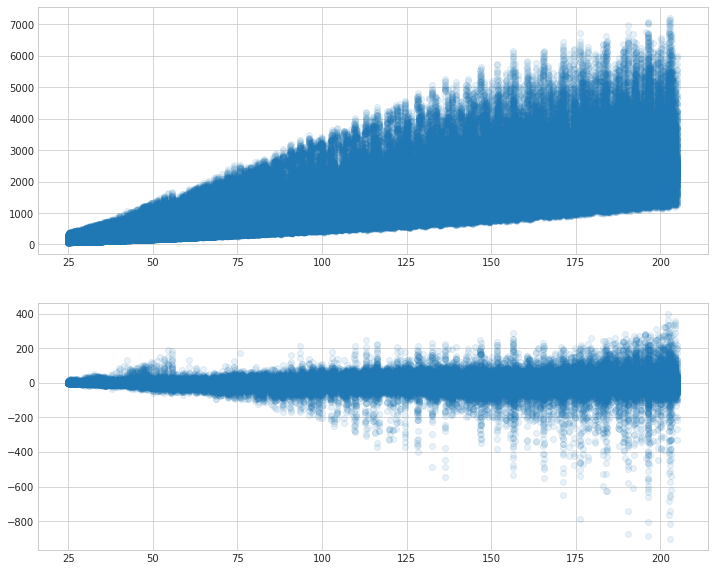

In [9]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [12, 10]

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.ion()

fig.show()
fig.canvas.draw()


max_epochs = 5
K = 1

# Data for the validation
with torch.no_grad():
    Xvalidation = torch.tensor(df_val.values, dtype=torch.float64,requires_grad=False)
    Yvalidation = torch.tensor(y_val.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)
    Xtrain = torch.tensor(df_train.values, dtype=torch.float64,requires_grad=False)
    Ytrain = torch.tensor(y_train.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)

# Launch the Training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print("\nSTART TRAINING")
# Loop over epochs


def rmse_loss(ypred, y):
    return torch.mean( torch.sqrt((ypred-y)**2) / y )


act_func = 'Relu'


for epoch in range(max_epochs):
    # Training
    model.train()
    for local_batch, local_labels in enumerate(dataloader):
        X = local_labels[0]
        y = local_labels[1]
        y = y.unsqueeze(-1)
        y_pred = model(X,'Relu')[0]
        loss = criterion(y_pred, y)
        rmse_val_loss = rmse_loss(y_pred,y)
        
        # Backward with gradient descent
        optimizer.zero_grad()
#        loss.backward()
        rmse_val_loss.backward()
        optimizer.step()
        
        # Compute Evaluation metrics
    
    #bar.finish()
    model.eval()
    with torch.no_grad():

        Xvalidation = torch.tensor(df_val.values, dtype=torch.float64,requires_grad=False)
        Yvalidation = torch.tensor(y_val.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)
        Xtrain = torch.tensor(df_train.values, dtype=torch.float64,requires_grad=False)
        Ytrain = torch.tensor(y_train.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)
        
        yvalidation_pred = model(Xvalidation,'Relu')[0]
        loss_val = criterion(yvalidation_pred, Yvalidation)
        rmse_val = rmse_loss(yvalidation_pred, Yvalidation)        

        ytrain_pred = model(Xtrain,'Relu')[0]
        loss_train = criterion(ytrain_pred, Ytrain)
        rmse_train = rmse_loss(ytrain_pred, Ytrain)        
        
        print("Validation MSE %.3f | Training MSE %.3f | Validation RMSE %.3f | Training RMSE %.3f\n"%(loss_val, loss_train, rmse_val, rmse_train))
        sys.stdout.flush()
 
    Xvalidation = torch.tensor(df_val.values, dtype=torch.float64,requires_grad=False)
    Yvalidation = torch.tensor(y_val.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)
    Xtrain = torch.tensor(df_train.values, dtype=torch.float64,requires_grad=False)
    Ytrain = torch.tensor(y_train.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)

    ax1.clear()
    ax1.plot(Xtrain[:,3], ytrain_pred.numpy(),'o',alpha=1/10)
    ax2.clear()
    ax2.plot(Xtrain[:,3],ytrain_pred.numpy()- Ytrain.numpy(),'o',alpha=1/10)
    fig.canvas.draw()

In [10]:
PATH = "./model_Q.pt"
model.save_model_state_dict(PATH)

In [12]:
PATH = "./model_Q.pt"
model.load_model_state_dict(PATH)

In [13]:
df

,Input_01,Input_02,Input_03,Input_04,Input_05,Input_06,Input_07,Input_08,OUTPUT
0,120,-69.000,-2000.0,43.296,25.000,-2.0000,1,State_01,147.701
1,120,-69.000,0.0,43.876,25.000,-2.0000,1,State_01,150.595
2,120,-69.000,2000.0,44.479,25.000,-2.0000,1,State_01,153.634
3,120,-69.000,5000.0,45.426,25.000,-2.0000,1,State_01,158.383
4,120,-69.000,10000.0,47.147,25.000,-2.0000,1,State_01,167.276
5,120,-69.000,14600.0,48.892,25.000,-2.0000,1,State_01,176.482
6,140,-69.000,-2000.0,43.296,25.000,-2.0000,1,State_01,150.164
7,140,-69.000,0.0,43.876,25.000,-2.0000,1,State_01,153.104
8,140,-69.000,2000.0,44.479,25.000,-2.0000,1,State_01,156.191
9,140,-69.000,5000.0,45.426,25.000,-2.0000,1,State_01,161.023


In [14]:
# Data for the validation
Xtest = torch.tensor(df_test.values, dtype=torch.float64)
Ytest = torch.tensor(y_test.values, dtype=torch.float64).unsqueeze(-1)

In [15]:
# Predictions
Xvalidation = torch.tensor(df_val.values, dtype=torch.float64,requires_grad=False)
Yvalidation = torch.tensor(y_val.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)
Xtrain = torch.tensor(df_train.values, dtype=torch.float64,requires_grad=False)
Ytrain = torch.tensor(y_train.values, dtype=torch.float64,requires_grad=False).unsqueeze(-1)


with torch.no_grad():
    yvalidation_pred = model(Xvalidation)[0]
    loss_val = criterion(yvalidation_pred, Yvalidation)

    ytrain_pred = model(Xtrain)[0]
    loss_train = criterion(ytrain_pred, Ytrain)
    
    ytest_pred = model(Xtest)[0]
    loss_test = criterion(ytest_pred, Ytest)
        
    print("Validation Loss %.3f | Training Loss %.3f\n"%(loss_val, loss_train))
    sys.stdout.flush()

Validation Loss 443.191 | Training Loss 447.397



In [16]:
# Dummy for the State
df_dummies = pd.get_dummies(df["Input_08"])
df_global = pd.concat([df.drop(['OUTPUT'], axis = 1), df_dummies], axis=1, join_axes=[df.index])


# Scale real Input
fit_colnames = ['Input_01','Input_02','Input_03','Input_04','Input_05','Input_06']
scaler = StandardScaler()
scaler.fit(df_global[fit_colnames])


# Split Dataset
df_train, df_test, y_train, y_test = train_test_split(df_global, df['OUTPUT'], test_size=0.4,random_state=42)
df_test, df_val, y_test, y_val = train_test_split(df_test, y_test, test_size=0.5,random_state=42)

In [17]:
df_train

,Input_01,Input_02,Input_03,Input_04,Input_05,Input_06,Input_07,Input_08,State_01,State_02,State_03,State_04,State_05,State_06
336550,180,0.00,2000.0,160.169,-40.000,2.00,2,State_03,0,0,1,0,0,0
753798,140,-69.00,0.0,174.526,10.000,-2.00,1,State_06,0,0,0,0,0,1
547946,275,-30.00,5000.0,169.462,25.000,0.00,2,State_04,0,0,0,1,0,0
345933,330,20.00,10000.0,48.644,-20.000,2.00,2,State_03,0,0,1,0,0,0
764952,310,-69.00,5000.0,60.216,10.000,2.00,2,State_06,0,0,0,0,0,1
590612,200,0.00,10000.0,115.938,-20.000,-2.00,1,State_05,0,0,0,0,1,0
623503,370,-30.00,10000.0,69.121,10.000,0.00,1,State_05,0,0,0,0,1,0
339255,370,20.00,5000.0,27.877,0.000,2.00,2,State_03,0,0,1,0,0,0
422277,210,20.00,-2000.0,25.099,0.000,2.00,1,State_04,0,0,0,1,0,0
707084,180,-30.00,5000.0,49.540,10.000,2.00,2,State_06,0,0,0,0,0,1


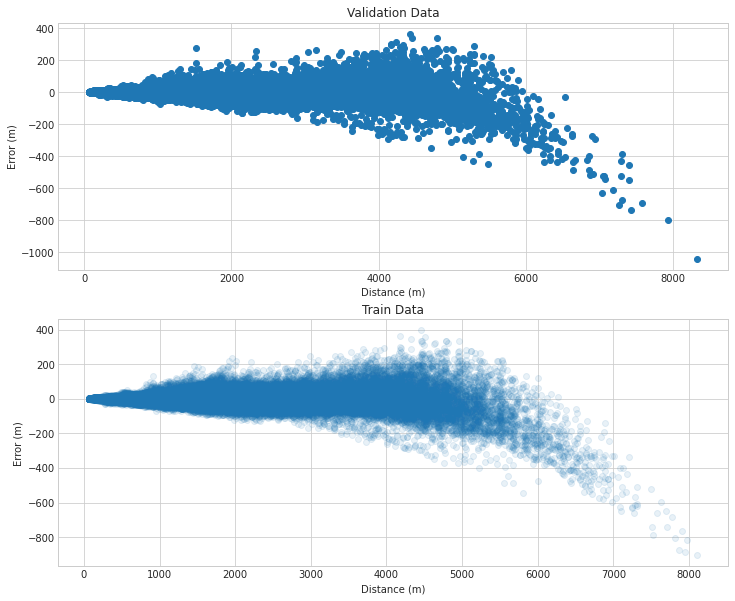

In [20]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.style.use('seaborn-whitegrid')

#print(Yval_error.squeeze(1).numpy())
#print(Yvalidation.squeeze(1).numpy())
df_val['Input_07']

plt.subplot(211)
Yval_error = yvalidation_pred - Yvalidation
plt.scatter(Yvalidation.squeeze(1).numpy(), Yval_error.squeeze(1).numpy()),
            #c=['State_03']+ 4*df_val['State_04']+ 5*df_val['State_05']+ 6*df_val['State_06'],
            #cmap="plasma")
plt.xlabel('Distance (m)')
plt.ylabel('Error (m)')
plt.title('Validation Data')

plt.subplot(212)
Ytrain_error = ytrain_pred - Ytrain
plt.plot(Ytrain, Ytrain_error,'o',alpha=1/10)
plt.xlabel('Distance (m)')
plt.ylabel('Error (m)')
plt.title('Train Data')
plt.show()

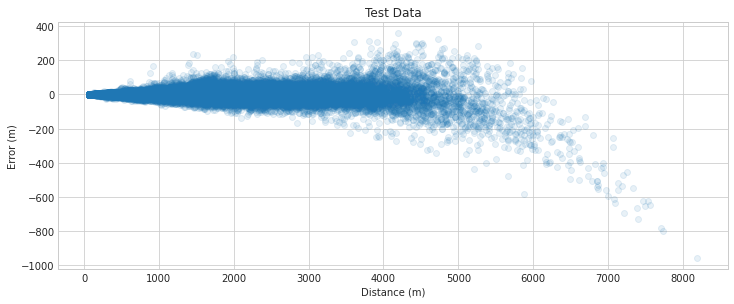

In [21]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.style.use('seaborn-whitegrid')

plt.subplot(211)
Ytest_error = ytest_pred - Ytest
plt.plot(Ytest, Ytest_error,'o',alpha=1/10)
plt.xlabel('Distance (m)')
plt.ylabel('Error (m)')
plt.title('Test Data')

plt.show()